In [1]:
from __future__ import division
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('scratch/hot100.csv')
# Manually correct tempo for a few example songs
tempo_fixes = {
    'Total Eclipse Of The Heart': .5,
    'Love Takes Time': .5,
}
for track, factor in tempo_fixes.items():
    orig = df.loc[
        df['track']==track,
        'tempo'
    ]
    df.loc[
        df['track']==track,
        'tempo'
    ] = orig * factor

In [3]:
tempo = df['tempo']
df['raw_tempo'] = tempo
# Set some reasonable extremes to scale by. Some songs have tempos of 0 (for some reason), or really 
# high tempos which are beat detection errors.
min_tempo = 52
max_tempo = 200
df['tempo'] = df['tempo'].clip(min_tempo, max_tempo)
scaled = (tempo - tempo.min())/(tempo.max()-tempo.min())
df['tempo'] = scaled

from datetime import timedelta as td, date
# e.g. 23/5/13
date_fmt = '%d/%m/%y'
df['datestr'] = df['entrance_date']
df['entrance_date'] = pd.to_datetime(df['entrance_date'], format=date_fmt)
future = df['entrance_date'] > date(year=2050,month=1,day=1)
df.loc[future, 'entrance_date'] -= td(days=365.25*100)

In [4]:
goodcols = ('artist,track,Year,energy,liveness,tempo,speechiness,acousticness,instrumentalness,'
            'valence,danceability').split(',') 
goodcols += ['entrance_date', 'peak', 'raw_tempo']

df = df[goodcols]

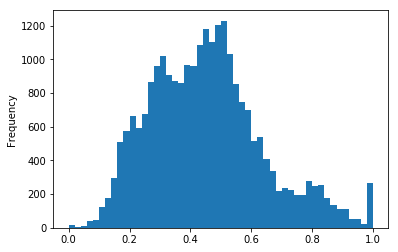

In [5]:
df['tempo'].plot.hist(bins=50);

In [6]:
df['raw_tempo'].describe()

count    24865.000000
mean       119.052499
std         27.691211
min          0.000000
25%         98.111000
50%        117.867000
75%        134.048000
max        242.510000
Name: raw_tempo, dtype: float64

In [7]:
#df.sort_values(by='raw_tempo', ascending=False).head(50)

In [8]:
df.head(3).T

,0,1,2
artist,Bill Haley & His Comets,Billy Vaughn & His Orchestra,Boots Brown
track,Lean Jean,La Paloma,Cerveza
Year,1958,1958,1958
energy,0.956276,0.404879,0.664677
liveness,0.325708,0.13608,0.083465
tempo,0.531419,0.377054,0.199838
speechiness,0.030649,0.02935,0.04658
acousticness,0.851513,0.776398,0.626037
instrumentalness,0.000519,0.908266,0.900513
valence,0.961398,0.660634,0.868803


In [9]:
df[df['artist']=='Bonnie Tyler']

,artist,track,Year,energy,liveness,tempo,speechiness,acousticness,instrumentalness,valence,danceability,entrance_date,peak,raw_tempo
11312,Bonnie Tyler,It's A Heartache,1978,0.500173,0.975181,0.454426,0.038696,0.763319,0.000000,0.659909,0.657975,1978-03-25,3,119.2550
13488,Bonnie Tyler,Total Eclipse Of The Heart,1983,0.626167,0.125216,0.088240,0.045836,0.089935,0.000000,0.190484,0.436914,1983-07-16,1,65.0595
13661,Bonnie Tyler,Take Me Back,1984,0.868986,0.304806,0.447101,0.055955,0.012678,0.000000,0.424555,0.389980,1983-12-03,46,118.1710
13749,Bonnie Tyler,Holding Out For A Hero,1984,0.878372,0.539318,0.655824,0.059811,0.024084,0.000007,0.896900,0.597593,1984-02-25,34,149.0620
13941,Bonnie Tyler,Here She Comes,1984,0.632062,0.051641,0.287993,0.025277,0.310663,0.000026,0.908286,0.711255,1984-08-11,76,94.6230
14592,Bonnie Tyler,If You Were A Woman (And I Was A Man),1986,0.892377,0.309308,0.499973,0.078869,0.543402,0.000000,0.682427,0.576922,1986-04-12,77,125.9960


In [10]:
df.groupby('artist').size().sort_values(ascending=False).head(5)

artist
Glee Cast          157
Elvis Presley      103
James Brown         91
Aretha Franklin     71
Ray Charles         71
dtype: int64

In [11]:
good_sonic_attrs = ('energy liveness tempo speechiness acousticness instrumentalness '
                       'valence danceability'
                      ).split()
bad_sonic_attrs = ['mode', 'time_signature', 'key']
numeric_sonic_attrs = good_sonic_attrs
nsa = numeric_sonic_attrs

# slooooooow
def add_mean_attrs(df):
    for date in df['entrance_date'].value_counts().index:
        idate = df['entrance_date'] == date
        if date.year == 1958:
            iprev = df['Year'] == 1958
        else:
            delta = date - df['entrance_date']
            iprev = (delta > td(days=0)) & (delta <= td(days=365))
        for sonic in nsa:
            col = 'mean_{}'.format(sonic)
            df.loc[idate, col] = df.loc[iprev, sonic].mean()

            
def preprocess(df):
    df = df.copy()
    add_mean_attrs(df)
    df = df[df['peak']==1]
    return df

In [12]:
%%time
# without typicality recalculation: ~3 min
# with: ~10min
dfx = preprocess(df)

CPU times: user 2min 6s, sys: 112 ms, total: 2min 6s
Wall time: 2min 7s


In [13]:
dfx.head(3).T

,30,65,89
artist,Tommy Edwards,Conway Twitty,Teddy Bears
track,It's All In The Game,It's Only Make Believe,"To Know Him, Is To Love Him"
Year,1958,1958,1958
energy,0.269397,0.268559,0.217606
liveness,0.209688,0.111408,0.155084
tempo,0.353027,0.220959,0.830912
speechiness,0.029153,0.032924,0.030544
acousticness,0.360193,0.963547,0.927009
instrumentalness,0,0.002049,3.1e-05
valence,0.643484,0.321706,0.284399


In [26]:
# Load spotify ids
ids = pd.read_csv('spotify_ids.txt')
assert len(ids) == len(dfx)
dfx.loc[:,'spotify_id'] = ids.values

In [27]:
pd.isnull(dfx['spotify_id']).sum()

0

In [28]:
dfx.head()

,artist,track,Year,energy,liveness,tempo,speechiness,acousticness,instrumentalness,valence,...,raw_tempo,mean_energy,mean_liveness,mean_tempo,mean_speechiness,mean_acousticness,mean_instrumentalness,mean_valence,mean_danceability,spotify_id
30,Tommy Edwards,It's All In The Game,1958,0.269397,0.209688,0.353027,0.029153,0.360193,0.000000,0.643484,...,104.248,0.491002,0.225826,0.430268,0.060453,0.697272,0.106669,0.673643,0.527676,01OFUZ8btJxFI6n5igQUqx
65,Conway Twitty,It's Only Make Believe,1958,0.268559,0.111408,0.220959,0.032924,0.963547,0.002049,0.321706,...,84.702,0.491002,0.225826,0.430268,0.060453,0.697272,0.106669,0.673643,0.527676,4qyV2fTVF9mCzgrekHny1v
89,Teddy Bears,"To Know Him, Is To Love Him",1958,0.217606,0.155084,0.830912,0.030544,0.927009,0.000031,0.284399,...,174.975,0.491002,0.225826,0.430268,0.060453,0.697272,0.106669,0.673643,0.527676,12UGU3ev7jEYzTG8r25H8J
98,Kingston Trio,Tom Dooley,1958,0.259362,0.630854,0.311426,0.070079,0.899686,0.000054,0.378037,...,98.091,0.491002,0.225826,0.430268,0.060453,0.697272,0.106669,0.673643,0.527676,2qLxtO0iaFGI9x19vU3bDI
166,Platters,Smoke Gets In Your Eyes,1959,0.269220,0.129334,0.423432,0.031002,0.954574,0.004874,0.163772,...,114.668,0.491002,0.225826,0.430268,0.060453,0.697272,0.106669,0.673643,0.527676,1s9tooJJ0gNHzzv9V52tln


In [18]:
len(ids)

1038

In [29]:
final_cols = ('artist,track,Year,energy,liveness,tempo,speechiness,acousticness,instrumentalness,'
            'valence,danceability,mean_energy,mean_liveness,mean_tempo,mean_speechiness,'
            'mean_acousticness,mean_instrumentalness,mean_valence,mean_danceability,spotify_id').split(',')

dfx[final_cols].to_csv('number_ones.csv', index=False)